**Post-processing and cleaning of sg643 deployment**
* Physics data cleaned
* Auxillary variables derived
* Horizontal Gridding
* Thermal Lag error analysis


In [1]:
%pylab inline

import glidertools as gt
from cmocean import cm as cmo  
import gsw
import xarray as xr
import os

sys.path.insert(0, '/Users/isabelle/Documents/src/code/my_python/ctdCalibration')
import agulhas_ctd

Populating the interactive namespace from numpy and matplotlib


/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/glidertools/mapping.py:1336: GliderToolsWarning: PyKrige is not installed. To enable the variogram function please run `pip install pykrige`. Variograms are required for sensible 2D interpolation.
  warnings.warn(message, category=GliderToolsWarning)


In [2]:
# Plotting
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':16})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [3]:
datadir ='/Users/isabelle/Documents/src/roammiz/data/sg643/raw_201812_201903/'
filenames = 'p6430*.nc'


In [4]:
# Load physics (C,T) and biochemistry (O2, phyto)

names = [
    'ctd_depth',
    'ctd_time',
    'ctd_pressure',
    'salinity',
    'temperature',
    'salinity_raw',
    'temperature_raw'
]

ds_dict = gt.load.seaglider_basestation_netCDFs(os.path.join(datadir,filenames), names, return_merged=False, keep_global_attrs=False)


DIMENSION: ctd_data_point
{longitude, salinity, latitude, ctd_depth, ctd_pressure, salinity_raw, temperature, temperature_raw, ctd_time}


100%|██████████| 487/487 [00:05<00:00, 81.28it/s]


In [5]:
dat = ds_dict['ctd_data_point']

dat = dat.rename({
    'salinity': 'salt',
    'temperature': 'temp',
    'salinity_raw': 'salt_raw',
    'temperature_raw': 'temp_raw',
    'ctd_pressure': 'pressure',
    'ctd_depth': 'depth',
    'ctd_time_dt64': 'time',
    'ctd_time': 'time_raw',
    
    })



In [6]:
x = dat.dives
y = dat.depth
pres = dat.pressure
lats = dat.latitude
lons = dat.longitude

# How did the glider sample?
Some of this analysis makes up Figure 1

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.94


/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/glidertools/helpers.py:69: GliderToolsWarning:

Primary input variable is not xr.DataArray data type - no metadata to pass on.



(0, 7.5)

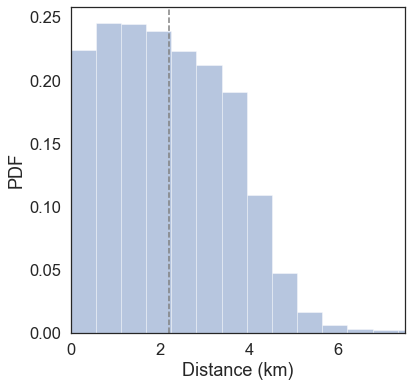

In [136]:
# Histogram of glider sample distances

dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]

dist_gridded = gt.grid_data(x, y, dist[:-1])


import seaborn as sns
plt.figure(figsize=[6, 6])
sns.set(font_scale=1.5)
sns.set_style('white')


sns.distplot(np.diff(dist_gridded[:,:],axis=1)/1000,bins=20,norm_hist=True,kde=False)
plt.axvline(np.nanmean(np.diff(dist_gridded[:,:],axis=1)/1000),linestyle='dashed',c='grey')
plt.ylabel('PDF')
plt.xlabel('Distance (km)')
plt.xlim(0,7.5)
#plt.savefig('/Users/isabelle/src/roammiz/figures/sg643_divedistance2.png',bbox_inches='tight',transparent=True)

In [133]:
np.nanstd(np.diff(dist_gridded[:,:],axis=1)/1000)

1.4406055875575492

In [134]:
# Add heat map of dive locations
lon_gridded = gt.grid_data(x, y, dat.longitude)
lat_gridded = gt.grid_data(x, y, dat.latitude)



Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.00
Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.00


Text(-0.4, -59.75, 'Bow-tie')

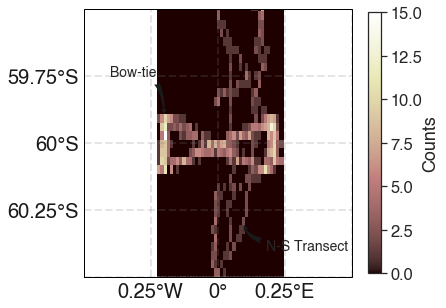

In [135]:
# Plot of glider sampling density

import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':18})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

projection =ccrs.PlateCarree()#
data_crs=ccrs.PlateCarree()
fig=plt.figure(figsize=[6,6])
ax = plt.axes(projection=projection)


#img=plt.hist2d( lon_gridded.values[10, :][~np.isnan(lon_gridded.values[10, :])], lat_gridded.values[10, :][~np.isnan(lat_gridded.values[10, :])], 
#           cmap=plt.cm.bone_r, bins=40,transform=data_crs)

img=plt.hist2d( lon_gridded.values[10, :][~np.isnan(lon_gridded.values[10, :])], lat_gridded.values[10, :][~np.isnan(lat_gridded.values[10, :])], 
           cmap=plt.cm.pink, bins=40,transform=data_crs)

ax.set_extent([-0.5,0.5,-60.5,-59.5])
#cax,kw = matplotlib.colorbar.make_axes(ax,location='top')
#out=fig.colorbar(img,cax=cax,**kw)
#cax,kw = matplotlib.colorbar.make_axes(ax,location='top',pad=0.01,shrink=0.7)
cb=plt.colorbar(shrink=0.8)
cb.set_label('Counts', labelpad=0.01)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#gl.xlines = False
gl.xlocator = mticker.FixedLocator([-0.5,-0.25, 0, 0.25,0.5])
gl.ylocator = mticker.FixedLocator([-60.5,-60.25,-60,-59.75,-59,-58.5,-58])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 20, 'color': 'k'}

gl.ylabel_style = {'size': 20, 'color': 'k'}

ax.annotate('N-S Transect', xy=(0.1,-60.3),  xycoords='data',
            xytext=(0.18,-60.4),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('Bow-tie', xy=(-0.2,-59.9),  xycoords='data',
            xytext=(-0.4,-59.75),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

#plt.savefig('/Users/isabelle/src/roammiz/figures/sg643_diveheatmap3.png',transparent=False,bbox_inches='tight',dpi=100)






# Compare to ship ctd


In [13]:
# Load bottle data
ctd_miz, date_miz, lon_miz, lat_miz = agulhas_ctd.read_ship_CTD('/Users/isabelle/src/roammiz/data/sg643/SANAE_58_Processed/stn003/stn003.cnv')
ctd_miz2, date_miz2, lon_miz2, lat_miz2 = agulhas_ctd.read_ship_CTD('/Users/isabelle/src/roammiz/data/sg643/SANAE_58_Processed/stn036/stn036.cnv')

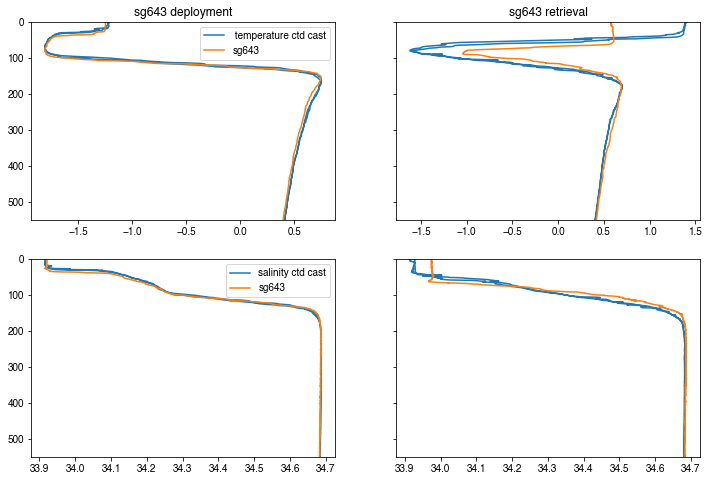

In [20]:
fig,ax=plt.subplots(2,2,figsize=[12,8],sharey=True)
#ax[0].plot(ctd_miz['sbeox0ML/L: Oxygen, SBE 43 [ml/l]'],ctd_miz['Pressure[db]'])
ax[0,0].set_title('sg643 deployment')
ax[0,0].plot(ctd_miz['Temperature'],ctd_miz['Pressure[db]'],label=' temperature ctd cast')
ax[0,0].plot(dat.temp[dat.dives==5.5],dat.depth[dat.dives==5.5],label='sg643')
ax[0,0].legend()

ax[0,1].set_title('sg643 retrieval')
ax[0,1].plot(ctd_miz2['Temperature'],ctd_miz2['Pressure[db]'])
ax[0,1].plot(dat.temp[dat.dives==503.5],dat.depth[dat.dives==503.5])
ax[0,1].set_ylim(550,0)

ax[1,0].plot(ctd_miz['Salinity'],ctd_miz['Pressure[db]'],label='salinity ctd cast')
ax[1,0].plot(dat.salt[dat.dives==5.5],dat.depth[dat.dives==5.5],label='sg643')
ax[1,0].legend()

ax[1,1].plot(ctd_miz2['Salinity'],ctd_miz2['Pressure[db]'])
ax[1,1].plot(dat.salt[dat.dives==503.5],dat.depth[dat.dives==503.5])
ax[1,1].set_ylim(550,0)


plt.savefig('/Users/isabelle/src/roammiz/data/sg643/t&scal.png')

## Clean and Grid

In [7]:
for key in dat:
    dat[key][x==55.0]=np.nan
    dat[key][x==64.5]=np.nan

In [8]:
# Reload with updated dives
x = dat.dives
y = dat.depth
pres = dat.pressure
lats = dat.latitude
lons = dat.longitude

In [9]:
dens0=gt.physics.potential_density(dat.salt, dat.temp, pres, lats, lons)
dens0_raw=gt.physics.potential_density(dat.salt_raw, dat.temp_raw, pres, lats, lons)

In [10]:
mld= gt.physics.mixed_layer_depth(x, y, dens0,ref_depth=10, thresh=0.03)
mld_raw = gt.physics.mixed_layer_depth(x, y, dens0_raw,ref_depth=10, thresh=0.03)
mld2=np.array(mld[::2])

In [11]:
# Clean temp and salnity, calculate density and mld
salt_qc=gt.cleaning.rolling_window(dat.salt, mean, window=3)
temp_qc=gt.cleaning.rolling_window(dat.temp, mean, window=3)
SA_qc=gsw.SA_from_SP(salt_qc,dat.depth,dat.longitude,dat.latitude)
CT_qc=gsw.CT_from_t(SA_qc,temp_qc,dat.depth)
dens0=gt.physics.potential_density(salt_qc, temp_qc, pres, lats, lons)
dens0_raw=gt.physics.potential_density(salt_qc, temp_qc, pres, lats, lons)


mld= gt.physics.mixed_layer_depth(x, y, dens0,ref_depth=10, thresh=0.03)
#n2=gsw.Nsquared(SA_qc,CT_qc,y)[1]


In [12]:
# Raw values - used later for thermal lag analysis

salt_qc_raw=gt.cleaning.rolling_window(dat.salt_raw, mean, window=3)
temp_qc_raw=gt.cleaning.rolling_window(dat.temp_raw, mean, window=3)
SA_qc_raw=gsw.SA_from_SP(salt_qc_raw,dat.depth,dat.longitude,dat.latitude)
CT_qc_raw=gsw.CT_from_t(SA_qc_raw,temp_qc_raw,dat.depth)

In [21]:
dat['SA_qc']=xr.DataArray(SA_qc,dims=('ctd_data_point'))
dat['CT_qc']=xr.DataArray(CT_qc,dims=('ctd_data_point'))
dat['dens0']=xr.DataArray(dens0,dims=('ctd_data_point'))

In [14]:
#dat.reset_coords().to_netcdf(os.path.join(datadir,'sg643_clean.nc'))

In [113]:
# Horizontal Linear Gridding method
time_raw=np.int64(dat.time)//10**9 * 10**9
dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]
dens0 = dat.dens0
hdist=np.arange(0,2074322,1000)


In [114]:

def mygridding_pressure(dives,depth,var):

    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = dives.copy(), depth.copy()
    z = Series(var)
    y = array(depth)
    x = array(dives)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50

    #bins=np.arange(1027,1028,0.01)
    bins=np.arange(1,1000,1)



    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])

    how='mean'
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    
    return gridded



In [120]:
import pandas as pd


x=dat.dives
y=dat.depth

dist_binned = mygridding_pressure(x, y, dist[:-1]).T
lat_binned = mygridding_pressure(x, y, dat.latitude).T
lon_binned = mygridding_pressure(x, y, dat.longitude).T
temp_binned = mygridding_pressure(x, y, dat.CT_qc).T
salt_binned = mygridding_pressure(x, y, dat.SA_qc[:]).T
dens_binned = mygridding_pressure(x, y, dat.dens0[:]).T
time_binned = mygridding_pressure(x, y, time_raw).T


xi=np.arange(0,999,1)

# Then interpolate on the horizontal


salt_horz=[]
temp_horz=[]
dens_horz=[]
time_horz=[]
lon_horz=[]
lat_horz=[]


for i in range(len(xi)-1):
        dens_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],dens_binned.iloc[:,i])).rolling(1).mean())
        temp_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],temp_binned.iloc[:,i])).rolling(1).mean())
        salt_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],salt_binned.iloc[:,i])).rolling(1).mean())
        lat_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],lat_binned.iloc[:,i])).rolling(1).mean())
        lon_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],lon_binned.iloc[:,i])).rolling(1).mean())

        time_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],time_binned.iloc[:,i])).rolling(1).mean())

dens_horz=np.array(dens_horz)
time_horz=np.array(time_horz)
lon_horz=np.array(lon_horz)
lat_horz=np.array(lat_horz)
salt_horz=np.array(salt_horz)
temp_horz=np.array(temp_horz)


time=np.array(pd.to_datetime(pd.Series(time_horz.flatten()//10**9*10**9))).reshape(len(xi)-1,np.size(hdist))

#####################################

glider_linterp = xr.Dataset(
                 data_vars={
                     'lat':  (('depth','distance'), lat_horz),
                     'lon':  (('depth','distance'), lon_horz),
                     'time':    (('depth','distance'), time),
                     'salt': (('depth','distance'),salt_horz ),
                     'temp': (('depth','distance'),temp_horz ),
                     'dens': (('depth','distance'),dens_horz )
                     },
                 coords={'depth': xi[:-1],
                         'distance': hdist},)

In [122]:
glider_linterp.attrs["processing"] = "This data has been cleaned, gridded onto equal pressure surfaces and linearly interpolated to 1km horizontal resolution"

In [129]:
glider_linterp.reset_coords().to_netcdf('/Users/isabelle/Documents/src/roammiz/data/sg643/sg643_linterp.nc')

In [ ]:
# Linearly grid data along isopycnals

In [100]:

def mygridding(dives,depth,var):

    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = dives.copy(), depth.copy()
    z = Series(var)
    y = array(depth)
    x = array(dives)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50

    bins=np.arange(1027,1028,0.01)
    #bins=np.arange(1,1000,1)



    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])

    how='mean'
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    
    return gridded


In [125]:
import pandas as pd

x=dat.dives
y=dens0

dist_binned = mygridding(x, y, dist[:-1]).T
lat_binned = mygridding(x, y, dat.latitude).T
lon_binned = mygridding(x, y, dat.longitude).T
temp_binned = mygridding(x, y, dat.CT_qc).T
salt_binned = mygridding(x, y, dat.SA_qc[:]).T
dens_binned = mygridding(x, y, dat.dens0[:]).T
time_binned = mygridding(x, y, time_raw).T

xi=np.arange(1027,1028,0.01)

salt_horz=[]
temp_horz=[]
dens_horz=[]
time_horz=[]
lon_horz=[]
lat_horz=[]

for i in range(len(xi)-1):
        dens_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],dens_binned.iloc[:,i])).interpolate())
        temp_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],temp_binned.iloc[:,i])).interpolate())
        salt_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],salt_binned.iloc[:,i])).interpolate())
        lat_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],lat_binned.iloc[:,i])).interpolate())
        lon_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],lon_binned.iloc[:,i])).interpolate())
        time_horz.append(pd.Series(np.interp(hdist,dist_binned.iloc[:,i],time_binned.iloc[:,i])).interpolate())

dens_horz=np.array(dens_horz)
time_horz=np.array(time_horz)
lon_horz=np.array(lon_horz)
lat_horz=np.array(lat_horz)
salt_horz=np.array(salt_horz)
temp_horz=np.array(temp_horz)

time=np.array(pd.to_datetime(pd.Series(time_horz.flatten()//10**9*10**9))).reshape(len(xi)-1,np.size(hdist))

#####################################

glider_linterp_dens = xr.Dataset(
                 data_vars={
                     'lat':  (('density','distance'), lat_horz),
                     'lon':  (('density','distance'), lon_horz),
                     'time':    (('density','distance'), time),
                     'salinity': (('density','distance'),salt_horz ),
                     'sea_water_temperature': (('density','distance'),temp_horz ),
                     'rho': (('density','distance'),dens_horz )
                     },
                 coords={'density': xi[:-1],
                         'distance': hdist})


In [126]:
glider_linterp_dens.attrs["processing"] = "This data has been cleaned, gridded onto equal density surfaces and linearly interpolated to 1km horizontal resolution"

In [128]:
# Save to nc
glider_linterp_dens.to_netcdf('/Users/isabelle/Documents/src/roammiz/data/sg643/sg643_grid_density_surfaces.nc')

# Compute thermal lag error

Disclaimer: this code is very hacky.  
I need to clean it up

In [77]:
test_dat=dat.groupby('dives')

In [18]:
def grid_data(
    x,
    y,
    var,
    bins=None,
    how='mean',
    interp_lim=6,
    verbose=True,
    return_xarray=True,
):
    """
    Grids the input variable to bins for depth/dens (y) and time/dive (x).
    The bins can be specified to be non-uniform to adapt to variable sampling
    intervals of the profile. It is useful to use the ``gt.plot.bin_size``
    function to identify the sampling intervals. The bins are averaged (mean)
    by default but can also be the ``median, std, count``,

    Parameters
    ----------
    x : np.array, dtype=float, shape=[n, ]
        The horizontal values by which to bin need to be in a psudeo discrete
        format already. Dive number or ``time_average_per_dive`` are the
        standard inputs for this variable. Has ``p`` unique values.
    y : np.array, dtype=float, shape=[n, ]
        The vertical values that will be binned; typically depth, but can also
        be density or any other variable.
    bins : np.array, dtype=float; shape=[q, ], default=[0 : 1 : max_depth ]
        Define the bin edges for y with this function. If not defined, defaults
        to one meter bins.
    how : str, defualt='mean'
        the string form of a function that can be applied to pandas.Groupby
        objects. These include ``mean, median, std, count``.
    interp_lim : int, default=6
        sets the maximum extent to which NaNs will be filled.

    Returns
    -------
    glider_section : xarray.DataArray, shape=[p, q]
        A 2D section in the format specified by ``ax_xarray`` input.

    Raises
    ------
    Userwarning
        Triggers when ``x`` does not have discrete values.
    """
    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = x.copy(), y.copy()
    z = Series(var)
    y = array(y)
    x = array(x)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50
    optimal_bins, avg_sample_freq = get_optimal_bins(y, chunk_depth)
    if bins is None:
        bins = optimal_bins

    # warning if bin average is smaller than average bin size
    if verbose:
        avg_bin_size = diff(bins).mean()
        print(
            (
                'Mean bin size = {:.2f}\n'
                'Mean depth binned ({} m) vertical sampling frequency = {:.2f}'
            ).format(avg_bin_size, chunk_depth, avg_sample_freq)
        )

    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))

    if interp_lim > 0:
        gridded = gridded.interpolate(limit=interp_lim).bfill(limit=interp_lim)

    if not return_xarray:
        return gridded

    if return_xarray:
        dummy = transfer_nc_attrs(getframe(), var, var, '_vert_binned')

        xda = gridded.stack().to_xarray()
        if isinstance(var, DataArray):
            xda.attrs = dummy.attrs
            xda.name = dummy.name

        if isinstance(yvar, DataArray):
            y = xda.dims[0]
            xda[y].attrs = yvar.attrs
            xda = xda.rename({y: yvar.name})

        if isinstance(xvar, DataArray):
            x = xda.dims[1]
            xda[x].attrs = xvar.attrs
            xda = xda.rename({x: xvar.name})

        return xda


def get_optimal_bins(depth, chunk_depth=50, round_up=True):
    """
    Uses depth data to estimate the optimal bin depths for gridding.

    Data is grouped in 50 m chunks (default for chunk_depth) where the
    average sequential depth difference is used to estimate the binning
    resolution for that chunk. The chunk binning resolution is rounded to
    the upper/lower 0.5 metres (specified by user).

    Parameters
    ----------
    depth : array
        A sequential array of depth (concatenated dives)
    chunk_depth : float=50
        chunk depth over which the bin sizes will be calculated
    round_up : True
        if True, rounds up to the nearest 0.5 m, else rounds down.

    Returns
    -------
    bins : array
    bin_avg_sampling_freq : float
        un-rounded depth weighted depth sampling frequency (for verbose use)

    """

    from numpy import (
        abs,
        arange,
        array,
        diff,
        ceil,
        floor,
        isnan,
        nanmax,
        nanmedian,
    )

    y = array(depth)
    bins = []
    bin_avg_sampling_freq = []

    if round_up:
        round_func = ceil
    else:
        round_func = floor

    d0 = 0
    d1 = chunk_depth
    last_freq = 0.5
    while d0 <= nanmax(depth):
        i = (y > d0) & (y < d1)

        bin_avg_sampling_freq += (nanmedian(abs(diff(y[i]))),)
        bin_freq = round_func(bin_avg_sampling_freq[-1] * 2) / 2
        if bin_freq == 0:
            bin_freq = 0.5
        elif isnan(bin_freq):
            bin_freq = last_freq
        bin_step = arange(d0, d1, bin_freq).tolist()
        bins += bin_step

        d0 = bin_step[-1] + bin_freq
        d1 = d0 + chunk_depth

        last_freq = bin_freq

    return array(bins), nanmedian(bin_avg_sampling_freq)


def grid_flat_dataarray(xda, bins=None):
    """
    Will grid an xr.DataArray if it contains coordinates correct metadata

    Parameters
    ----------
    xda : xr.DataArray
        flattened profile array with coordinates:
        (axis='T' | 'time' in name) and (axis='Z' | 'depth' in name)

    Returns a gridded dataset
    -------------------------
    """
    from .helpers import GliderToolsError

    has_requirements = 0
    for key in xda.coords:
        coord = xda[key]
        attrs = coord.attrs
        if ('Z' in attrs.get('axis', '').upper()) | ('depth' in coord.name):
            depth = coord
            has_requirements += 1
        if 'dives' in coord.name:
            dives = coord
            has_requirements += 1
    if has_requirements == 2:
        x = dives
        y = depth
        z = xda

        gridded = grid_data(
            x, y, z, bins=bins, return_xarray=True, verbose=False
        )
        return gridded
    else:
        raise GliderToolsError(
            'The array coordinates do not contain axis info for gridding'
        )




In [16]:
def mygridding(var,dives,depth):

    from pandas import cut, Series
    from xarray import DataArray
    from numpy import array, c_, unique, diff

    xvar, yvar = dives.copy(), depth.copy()
    z = Series(var)
    y = array(depth)
    x = array(dives)

    u = unique(x).size
    s = x.size
    if (u / s) > 0.2:
        raise UserWarning(
            'The x input array must be psuedo discrete (dives or dive_time). '
            '{:.0f}% of x is unique (max 20% unique)'.format(u / s * 100)
        )

    chunk_depth = 50

    bins=np.arange(0,1000,1)

    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(y, bins, labels=labels)

    grp = Series(z).groupby([x, bins])

    how='mean'
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    
    return gridded

#optimal_bins, avg_sample_freq = get_optimal_bins(y, chunk_depth)

In [19]:
salt_grid=mygridding(dat.salt,dat.dives,dat.depth)
temp_grid = mygridding(dat.temp,dat.dives,dat.depth)
salt_grid_raw=mygridding(dat.salt_raw,dat.dives,dat.depth)
temp_grid_raw=mygridding(dat.temp_raw,dat.dives,dat.depth)

In [20]:
dens_grid = mygridding(dens0,dat.dives,dat.depth)
dens_grid_raw=mygridding(dens0_raw,dat.dives,dat.depth)

In [21]:
### TEMPERATURE
diff_temp=[]
for i in np.arange(1,971,2):
    diff_temp.append(np.array(temp_grid.iloc[:,i]-temp_grid.iloc[:,i+1]))
diff_temp=np.array(diff_temp)
diff_temp_raw=[]
for i in np.arange(1,971,2):
    diff_temp_raw.append(np.array(temp_grid_raw.iloc[:,i]-temp_grid_raw.iloc[:,i+1]))
diff_temp_raw=np.array(diff_temp_raw)

temp_mean_raw=np.nanmean(diff_temp_raw,0)
temp_std_raw=np.nanstd(diff_temp_raw,0)
temp_mean_corr=np.nanmean(diff_temp,0)
temp_std_corr=np.nanstd(diff_temp,0)


### SALINITY
diff_salt=[]
for i in np.arange(1,971,2):
    diff_salt.append(np.array(salt_grid.iloc[:,i]-salt_grid.iloc[:,i+1]))
diff_salt=np.array(diff_salt)
diff_salt_raw=[]
for i in np.arange(1,971,2):
    diff_salt_raw.append(np.array(salt_grid_raw.iloc[:,i]-salt_grid_raw.iloc[:,i+1]))
diff_salt_raw=np.array(diff_salt_raw)

salt_mean_raw=np.nanmean(diff_salt_raw,0)
salt_std_raw=np.nanstd(diff_salt_raw,0)
salt_mean_corr=np.nanmean(diff_salt,0)
salt_std_corr=np.nanstd(diff_salt,0)

### DENSITY
diff_dens=[]
for i in np.arange(1,971,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(1,971,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

dens_mean_raw=np.nanmean(diff_dens_raw,0)
dens_std_raw=np.nanstd(diff_dens_raw,0)
dens_mean_corr=np.nanmean(diff_dens,0)
dens_std_corr=np.nanstd(diff_dens,0)

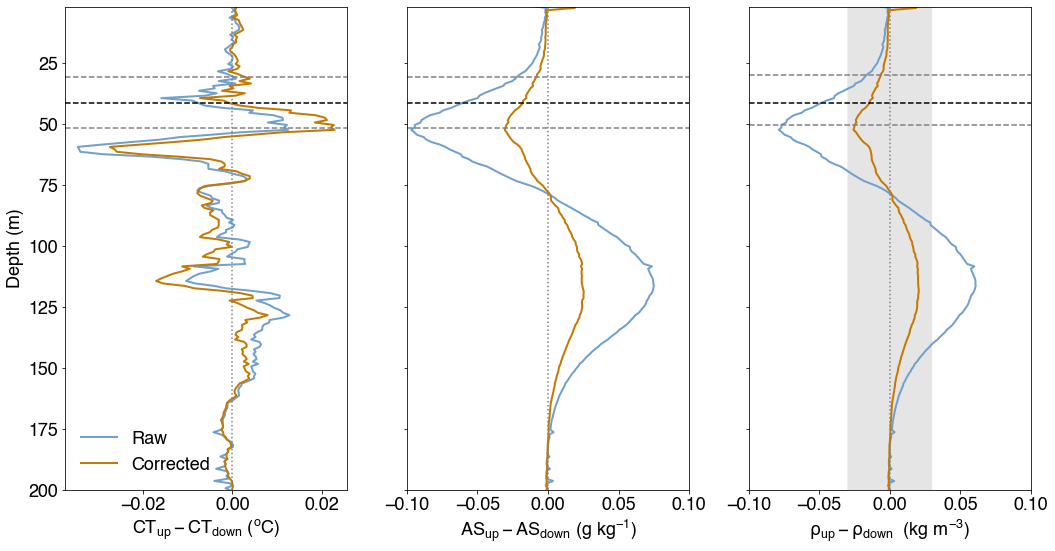

In [200]:
fig,ax=plt.subplots(1,3,figsize=[15,8],sharey=True)

raw = (112/255,160/255,205/255)
corr = (196/255,121/255,0)

#plt.rc('text', usetex=True, )
plt.rcParams.update({'font.size': 18})
ax[0].plot(temp_mean_raw[1:],temp_grid.index[1:],label='Raw',c=raw,linewidth=2)

ax[0].plot(temp_mean_corr,temp_grid.index,label='Corrected',c=corr,linewidth=2)

ax[0].axhline(y=np.nanmean(mld),c='k',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')

ax[0].axvline(x=0,c='Grey',linestyle=':')
ax[0].set_ylim(200,2)
ax[0].legend(frameon=False, loc='lower left')
ax[0].set_xlabel(u'$CT_{up}-CT_{down}\ (^{o}C)$')
#ax[0].text(0.01,185,'RMSE=2e$^{-4}$')

######################################################################


ax[1].plot(salt_mean_raw[:],salt_grid_raw.index[:],label='Raw',c=raw,linewidth=2)

ax[1].plot(salt_mean_corr[:],salt_grid.index[:],label='Corrected',c=corr,linewidth=2)
ax[1].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axhline(y=np.nanmean(mld),c='k',linestyle='--')

ax[1].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axvline(x=0,c='Grey',linestyle=':')
ax[1].set_ylim(200,2)
ax[1].set_xlim(-0.1,0.1)


#ax[1].legend(frameon=False)
ax[1].set_xlabel(u'$AS_{up}-AS_{down}$ (g kg$^{-1})$')
#ax[1].text(0.05,185,'RMSE=3e$^{-3}$')

######################################################################


ax[2].plot(dens_mean_raw[:],dens_grid_raw.index[:],label='Raw',c=raw,linewidth=2)
ax[2].plot(dens_mean_corr[:],dens_grid.index,label='Corrected',c=corr,linewidth=2)

ax[2].axhline(y=np.nanmean(mld.rolling(2).median()),c='k',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])-np.nanstd(mld[::2]),c='Grey',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])+np.nanstd(mld[::2]),c='Grey',linestyle='--')


ax[2].axvline(x=0,c='Grey',linestyle=':')
ax[2].fill_betweenx(dens_grid.index,-0.03,0.03,facecolor='Grey',alpha=0.2)

ax[2].set_ylim(200,2)
ax[2].set_xlim(-0.1,0.1)


#ax[2].legend(frameon=False)
ax[2].set_xlabel(u'$\\rho_{up}-\\rho_{down}$  (kg $m^{-3})$')
#ax[2].text(0.045,185,'RMSE=3e$^{-3}$')

ax[0].set_ylabel('Depth (m)')
plt.tight_layout()

plt.savefig('/Users/isabelle/src/roammiz/Figures/thermal_lag_ud.png',dpi=150)

In [22]:
### TEMPERATURE
diff_temp=[]
for i in np.arange(2,972,2):
    diff_temp.append(np.array(temp_grid.iloc[:,i]-temp_grid.iloc[:,i+1]))
diff_temp=np.array(diff_temp)
diff_temp_raw=[]
for i in np.arange(2,972,2):
    diff_temp_raw.append(np.array(temp_grid_raw.iloc[:,i]-temp_grid_raw.iloc[:,i+1]))
diff_temp_raw=np.array(diff_temp_raw)

temp_mean_raw=np.nanmean(diff_temp_raw,0)
temp_std_raw=np.nanstd(diff_temp_raw,0)
temp_mean_corr=np.nanmean(diff_temp,0)
temp_std_corr=np.nanstd(diff_temp,0)


### SALINITY
diff_salt=[]
for i in np.arange(2,972,2):
    diff_salt.append(np.array(salt_grid.iloc[:,i]-salt_grid.iloc[:,i+1]))
diff_salt=np.array(diff_salt)
diff_salt_raw=[]
for i in np.arange(2,972,2):
    diff_salt_raw.append(np.array(salt_grid_raw.iloc[:,i]-salt_grid_raw.iloc[:,i+1]))
diff_salt_raw=np.array(diff_salt_raw)

salt_mean_raw=np.nanmean(diff_salt_raw,0)
salt_std_raw=np.nanstd(diff_salt_raw,0)
salt_mean_corr=np.nanmean(diff_salt,0)
salt_std_corr=np.nanstd(diff_salt,0)

### DENSITY
diff_dens=[]
for i in np.arange(2,972,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(2,972,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

dens_mean_raw=np.nanmean(diff_dens_raw,0)
dens_std_raw=np.nanstd(diff_dens_raw,0)
dens_mean_corr=np.nanmean(diff_dens,0)
dens_std_corr=np.nanstd(diff_dens,0)

In [48]:
raw = (112/255,160/255,205/255)
corr = (196/255,121/255,0)

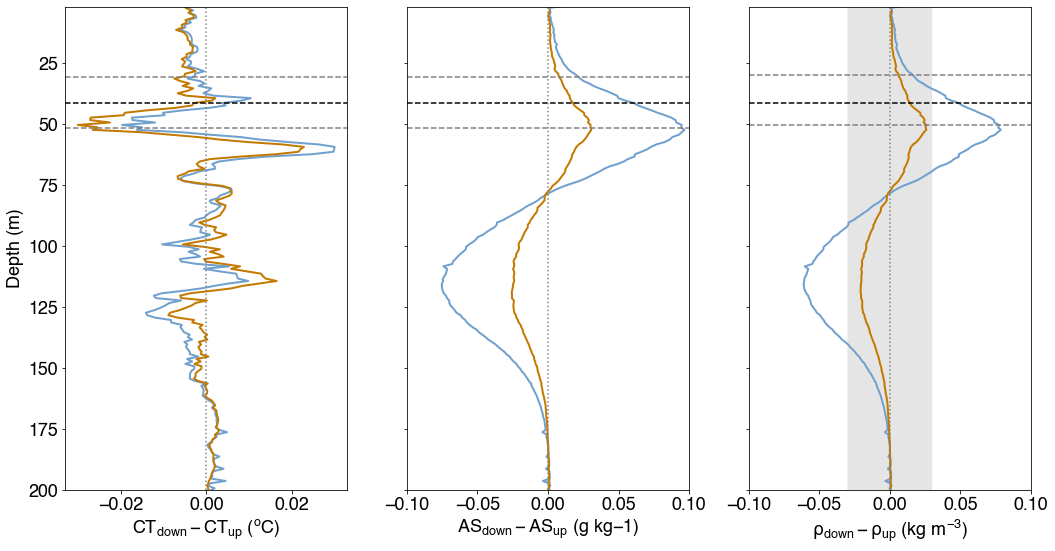

In [202]:
# Plot differeces in processing

fig,ax=plt.subplots(1,3,figsize=[15,8],sharey=True)



#plt.rc('text', usetex=True, )
plt.rcParams.update({'font.size': 18})
ax[0].plot(temp_mean_raw[1:],temp_grid.index[1:],label='Raw',c=raw,linewidth=2)

ax[0].plot(temp_mean_corr,temp_grid.index,label='Corrected',c=corr,linewidth=2)

ax[0].axhline(y=np.nanmean(mld),c='k',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[0].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')

ax[0].axvline(x=0,c='Grey',linestyle=':')
ax[0].set_ylim(200,0)
#ax[0].legend(frameon=False)
ax[0].set_xlabel(u'$CT_{down}-CT_{up}\ (^{o}C)$')
#ax[0].text(0.01,185,'RMSE=2e$^{-4}$')

######################################################################


ax[1].plot(salt_mean_raw[:],salt_grid_raw.index[:],label='Raw',c=raw,linewidth=2)

ax[1].plot(salt_mean_corr[:],salt_grid.index[:],label='Corrected',c=corr,linewidth=2)
ax[1].axhline(y=np.nanmean(mld)-np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axhline(y=np.nanmean(mld),c='k',linestyle='--')

ax[1].axhline(y=np.nanmean(mld)+np.nanstd(mld),c='Grey',linestyle='--')
ax[1].axvline(x=0,c='Grey',linestyle=':')
ax[1].set_ylim(200,2)
ax[1].set_xlim(-0.1,0.1)


#ax[1].legend(frameon=False)
ax[1].set_xlabel(u'$AS_{down}-AS_{up}$ (g $kg{-1})$')
#ax[1].text(0.05,185,'RMSE=3e$^{-3}$')


######################################################################



ax[2].plot(dens_mean_raw[:],dens_grid_raw.index[:],label='Raw',c=raw,linewidth=2)
ax[2].plot(dens_mean_corr[:],dens_grid.index,label='Corrected',c=corr,linewidth=2)

ax[2].axhline(y=np.nanmean(mld.rolling(2).median()),c='k',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])-np.nanstd(mld[::2]),c='Grey',linestyle='--')
ax[2].axhline(y=np.nanmean(mld[::2])+np.nanstd(mld[::2]),c='Grey',linestyle='--')


ax[2].axvline(x=0,c='Grey',linestyle=':')
ax[2].fill_betweenx(dens_grid.index,-0.03,0.03,facecolor='Grey',alpha=0.2)

ax[2].set_ylim(200,2)
ax[2].set_xlim(-0.1,0.1)


#ax[2].legend(frameon=False)
ax[2].set_xlabel(u'$\\rho_{down}-\\rho_{up}}$ (kg $m^{-3})$')
#ax[2].text(0.045,185,'RMSE=3e$^{-3}$')

ax[0].set_ylabel('Depth (m)')
plt.tight_layout()

plt.savefig('/Users/isabelle/src/roammiz/Figures/thermal_lag_du.png',dpi=150)

### Compute and plot differences in up/down down/up within the mixed layer 


In [36]:

### Density
diff_dens=[]
for i in np.arange(1,549,2):
    diff_dens.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))
   
diff_dens=np.array(diff_dens)
diff_dens_raw=[]
for i in np.arange(1,549,2):
    diff_dens_raw.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw=np.array(diff_dens_raw)

In [50]:
diff_dens2=[]
for i in np.arange(0,972,2):
    diff_dens2.append(np.array(dens_grid.iloc[:,i]-dens_grid.iloc[:,i+1]))

diff_dens2=np.array(diff_dens2)
diff_dens_raw2=[]
for i in np.arange(0,972,2):
    diff_dens_raw2.append(np.array(dens_grid_raw.iloc[:,i]-dens_grid_raw.iloc[:,i+1]))
diff_dens_raw2=np.array(diff_dens_raw2)

In [51]:
dist = np.r_[0, gt.utils.distance(dat.longitude, dat.latitude).cumsum()]
dist_grid=gt.grid_data(x, y, dist[:-1], verbose=False)

/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/glidertools/helpers.py:69: GliderToolsWarning:

Primary input variable is not xr.DataArray data type - no metadata to pass on.



In [52]:
# DISTANCE
diff_dist=[]
for i in np.arange(2,972,2):
 #   print(dist_grid.dives[i])
 #   print(dist_grid.dives[i+1])
 #   print('next')
    diff_dist.append(np.array(dist_grid[:,i]-dist_grid[:,i+1]))
diff_dist=np.array(diff_dist)

In [53]:
# DISTANCE
diff_dist2=[]
for i in np.arange(1,971,2):
 #   print(dist_grid.dives[i])
 #   print(dist_grid.dives[i+1])
 #   print('next')
    diff_dist2.append(np.array(dist_grid[:,i]-dist_grid[:,i+1]))
diff_dist2=np.array(diff_dist2)

In [54]:
dens_diff_mld=[]
depth_diff=[]

plt.figure()
#for i in range(len(mld2-2)):
for i in range(26):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))

        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        #plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append((np.nanmean(diff_count)))
        dens_diff_dist.append((np.nanmean(diff_count)))
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))
        


    except: print(i)
        
for i in range(28,163):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append((np.nanmean(diff_count)))
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: print(i)
        
dens_diff_mld=[]
depth_diff=[]   
diff_dist_mld=[]
for i in range(0,486):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(diff_Dist)
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: print(i)
        
 #   print(salt_diff[:(np.int8

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
14

<Figure size 432x288 with 0 Axes>

In [55]:
dens_diff_mld2=[]
depth_diff2=[]

plt.figure()
#for i in range(len(mld2-2)):
for i in range(26):

    try:
        diff_count2=((diff_dens2[i,3:(np.int8(mld[i])-15)]))
        diff_Dist2=((diff_dist2[i,3:(np.int8(mld[i])-15)]))

        plot(diff_count2,dens_grid.depth[3:(np.int8(mld[i])-15)])
        #plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld2.append((np.nanmean(diff_count2)))
        salt_diff_dist2.append((np.nanmean(diff_count2)))
        depth_diff2.append((dens_grid.depth[3:(np.int8(mld[i])-15)]))
        


    except: print(i)
        
for i in range(28,163):

    try:
        diff_count=((diff_dens2[i,3:(np.int8(mld[i])-15)]))
        plot(diff_count2,dens_grid.depth[3:(np.int8(mld[i])-15)])
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld2.append((np.nanmean(diff_count2)))
        depth_diff2.append((dens_grid.depth[3:(np.int8(mld[i])-15)]))



    except: print(i)
        
dens_diff_mld=[]
depth_diff=[]   
diff_dist_mld=[]
for i in range(0,486):

    try:
        diff_count=((diff_dens[i,3:(np.int8(mld2[i])-15)]))
        plot(diff_count,dens_grid.depth[3:(np.int8(mld2[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(diff_Dist)
       # plt.axhline(y=mld2[i])
        plt.ylim(150,10)
        dens_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        depth_diff.append((dens_grid.depth[3:(np.int8(mld2[i])-15)]))



    except: print(i)
        
 #   print(salt_diff[:(np.int8

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
14

<Figure size 432x288 with 0 Axes>

In [56]:
#up down
dens_diff_mld_raw=[]
dens_diff_mld=[]

depth_diff=[]   
diff_dist_mld=[]
for i in range(0,972):

    try:
        diff_count1=((diff_dens[i,10:(np.int8(mld2[i])-15)]))
        diff_count2=((diff_dens_raw[i,10:(np.int8(mld2[i])-15)]))

      #  plot(diff_count,salt_grid.depth[10:(np.int8(mld2.iloc[i])-15)])
        diff_Dist=((diff_dist[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld.append(np.nanmean(diff_Dist))
       # plt.axhline(y=mld2[i])
      #  plt.ylim(150,10)
        #salt_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        dens_diff_mld.append(((np.nanmean(diff_count1))/333)*1000)
        dens_diff_mld_raw.append(((np.nanmean(diff_count2))/333)*1000)


      #  depth_diff.append((salt_grid.depth[3:(np.int8(mld2.iloc[i])-15)]))



    except: print(i)

274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523


In [57]:
diff_dist2

array([[ -338.95193301,  -350.21594546,  -353.39222896, ...,
                   nan,            nan,            nan],
       [ -103.54362317,  -119.19688764,  -122.7814107 , ...,
                   nan,            nan,            nan],
       [ -234.49489504,  -246.65929505,  -247.81799804, ...,
                   nan,            nan,            nan],
       ...,
       [  -99.935805  ,  -116.25072388,  -120.41962663, ...,
                   nan,            nan,            nan],
       [  -80.26017792,   -83.34614056,   -85.23630059, ...,
                   nan,            nan,            nan],
       [ -142.55467864,  -146.69778964,  -150.56124017, ...,
        -4539.4903773 , -4539.4903773 , -4539.4903773 ]])

In [58]:
#down up
dens_diff_mld_raw2=[]
dens_diff_mld2=[]

depth_diff2=[]   
diff_dist_mld2=[]
for i in range(0,972):

    try:
        diff_count3=((diff_dens2[i,10:(np.int8(mld2[i])-15)]))
        diff_count4=((diff_dens_raw2[i,10:(np.int8(mld2[i])-15)]))

      #  plot(diff_count,salt_grid.depth[10:(np.int8(mld2.iloc[i])-15)])
        diff_Dist=((diff_dist2[i,3:(np.int8(mld2[i])-15)]))
        diff_dist_mld2.append(np.nanmean(diff_Dist))
       # plt.axhline(y=mld2[i])
      #  plt.ylim(150,10)
        #salt_diff_mld.append(((np.nanmean(diff_count))/(np.nanmean(diff_Dist)))*1000)
        dens_diff_mld2.append(((np.nanmean(diff_count3))/2000)*1000)
        dens_diff_mld_raw2.append(((np.nanmean(diff_count4))/2000)*1000)


      #  depth_diff.append((salt_grid.depth[3:(np.int8(mld2.iloc[i])-15)]))



    except: print(i)

485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734


In [59]:
import pandas as pd
sd=pd.Series(dens_diff_mld).interpolate()
sdRAW = pd.Series(dens_diff_mld_raw).interpolate()

sd2=pd.Series(dens_diff_mld2).interpolate()
sdRAW2 = pd.Series(dens_diff_mld_raw2).interpolate()

import seaborn as sns

Text(0.5, 0, '$ \\Delta$ kg m$^{-3}$ km$^{-1}$')

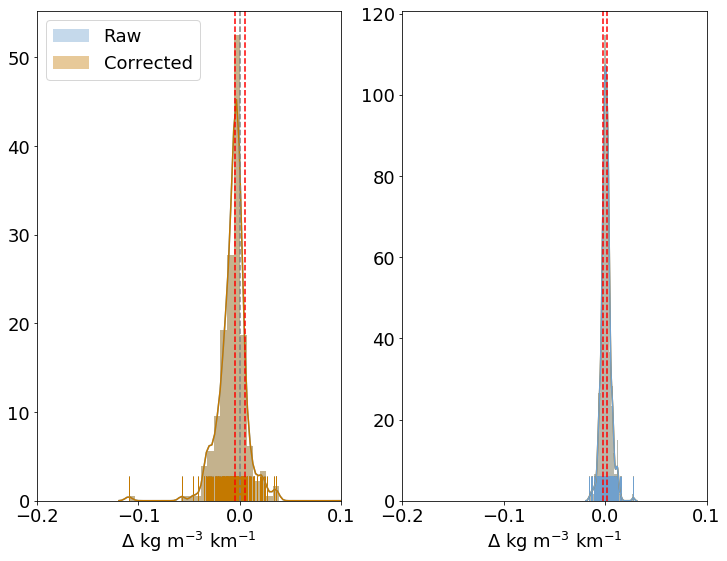

In [60]:
import seaborn as sns
plt.rcParams.update({'font.size': 18})


fig,ax=plt.subplots(1,2,figsize=[12,9],sharex=True)
sns.distplot(sdRAW, hist=True, rug=True,label='Raw',ax=ax[0],color=raw)


sns.distplot(sd, hist=True, rug=True,label='Corrected',ax=ax[0],color=corr)

sns.distplot(sdRAW2, hist=True, rug=True,label='Raw_DU',ax=ax[1],color=corr)
sns.distplot(sd2, hist=True, rug=True,label='Corrected_DU',ax=ax[1],color=raw)


ax[0].set_xlim(-0.2,0.1)
ax[0].axvline(0,c='Grey',linestyle='--')
ax[0].axvline(-0.005,c='r',linestyle='--')
ax[0].axvline(+0.005,c='r',linestyle='--')
ax[1].axvline(-0.002,c='r',linestyle='--')
ax[1].axvline(+0.002,c='r',linestyle='--')
ax[0].legend()

ax[0].set_xlabel(r'$ \Delta$ kg m$^{-3}$ km$^{-1}$')
ax[1].set_xlabel(r'$ \Delta$ kg m$^{-3}$ km$^{-1}$')

#ax[0].set_title('Up Down ')
#ax[1].set_title('Down Up ')

#plt.savefig('/Users/isabelle/src/roammiz/Figures/TL_analysis_dens.png',dpi=150)

In [ ]:
# rmsw= 0.005
# 0.002

